In [1]:
import dill as dill
from os import listdir
from os.path import isfile, join
from fall_2021_projection_utils import aggregate_trajs_student_only

paths = ['fall_2021_prior_samples:1633813108/', 
        'fall_2021_prior_samples:1633813076/',
        'fall_2021_prior_samples:1633813017/',
        'fall_2021_prior_samples:1633812978/']




In [2]:
sampled_points = {}
aggregated_trajs = {}

In [210]:

all_files = []
for path in paths:
    files = [join(path, f) for f in listdir(path) if isfile(join(path, f)) and 'with' in f]
    all_files = all_files + files
    
print("found {} prior point samples, ".format(len(all_files)))

count = 0
for f in all_files:
    if f in sampled_points:
        continue
    with open(f, "rb") as fhandle:
        [point, inf_trajs_by_group] = dill.load(fhandle)
        sampled_points[f] = point
        aggregated_trajs[f] = aggregate_trajs_student_only(inf_trajs_by_group)
    count += 1
    if count % 50 == 0:
        print("Loaded {} points".format(count))
        #break
    
        
        

found 11301 prior point samples, 
Loaded 50 points
Loaded 100 points
Loaded 150 points
Loaded 200 points
Loaded 250 points
Loaded 300 points
Loaded 350 points
Loaded 400 points
Loaded 450 points
Loaded 500 points
Loaded 550 points
Loaded 600 points
Loaded 650 points
Loaded 700 points
Loaded 750 points
Loaded 800 points
Loaded 850 points
Loaded 900 points
Loaded 950 points
Loaded 1000 points
Loaded 1050 points
Loaded 1100 points
Loaded 1150 points
Loaded 1200 points
Loaded 1250 points
Loaded 1300 points
Loaded 1350 points
Loaded 1400 points
Loaded 1450 points
Loaded 1500 points
Loaded 1550 points
Loaded 1600 points
Loaded 1650 points
Loaded 1700 points
Loaded 1750 points
Loaded 1800 points
Loaded 1850 points
Loaded 1900 points
Loaded 1950 points
Loaded 2000 points
Loaded 2050 points
Loaded 2100 points
Loaded 2150 points
Loaded 2200 points
Loaded 2250 points
Loaded 2300 points
Loaded 2350 points
Loaded 2400 points
Loaded 2450 points
Loaded 2500 points
Loaded 2550 points
Loaded 2600 point

In [211]:
len(sampled_points)

11301

In [212]:
import numpy as np

def convert_cum_traj_to_daily_count(traj):
    prev_cum_cases = 0
    daily_count = []
    for current_cum_cases in traj:
        daily_count.append(current_cum_cases - prev_cum_cases)
        prev_cum_cases = current_cum_cases
    return daily_count

def convert_daily_count_traj_to_weekly_count(daily_count_traj):
    weekly_count = []
    lower_idx = 0
    upper_idx = 7 
    while lower_idx <= len(daily_count_traj):
        weekly_count.append(sum(daily_count_traj[lower_idx:upper_idx]))
        lower_idx = upper_idx
        upper_idx += 7
    assert(np.abs(sum(weekly_count) - sum(daily_count_traj)) < 1e-5)
    return weekly_count

def get_weekly_counts(cum_traj):
    daily_count = convert_cum_traj_to_daily_count(cum_traj)
    return convert_daily_count_traj_to_weekly_count(daily_count)


    

In [213]:
from scipy.stats import norm
import numpy as np

ACTUAL_TRAJ = [2,2,11,23,42,57,55,39,31,48,42,25,29,4,9,8,13,14,8,8,1,7,8,5,3,6,3,0,3,4,9,3,8,1]#,0,0]

def compute_lognormal_loglik(cum_trajs):
    actual_weekly_traj = convert_daily_count_traj_to_weekly_count(ACTUAL_TRAJ)
    num_weeks = len(actual_weekly_traj)
    
    # estimate lognormal parameters
    log_counts_by_week = {week_idx:[] for week_idx in range(num_weeks)}
    for cum_traj in cum_trajs:
        weekly_counts = get_weekly_counts(cum_traj)
        for week_idx in range(num_weeks):
            log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx] + 1e-10))
            #log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx]))
    
    means_by_week = {week_idx: np.mean(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    stddevs_by_week = {week_idx: np.std(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    
    # compute log likelihood for observed data
    loglik = 0
    for week_idx, actual_positives in enumerate(actual_weekly_traj):
        log_positives = np.log(actual_positives)
        #scaled_log_positives = (log_positives - means_by_week[week_idx]) / stddevs_by_week[week_idx]
        #print(log_positives, means_by_week[week_idx], stddevs_by_week[week_idx], scaled_log_positives)
        loglik += norm.logpdf(log_positives, loc=means_by_week[week_idx], 
                                  scale=stddevs_by_week[week_idx])
    
    return loglik

#compute_lognormal_loglik(aggregated_trajs[f])

In [214]:
import numpy as np
logliks = {}
for f in sampled_points:
    logliks[f] = compute_lognormal_loglik(aggregated_trajs[f])
    #print("\n\n\n")

In [215]:
from fall_2021_projection_utils import UNCERTAINTY_PARAMS

param_vals = {}
param_logliks = {}

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    param_vals[param] = []
    param_logliks[param] = []
    for f in sampled_points:
        param_vals[param].append(sampled_points[f][idx])
        param_logliks[param].append(logliks[f])
    

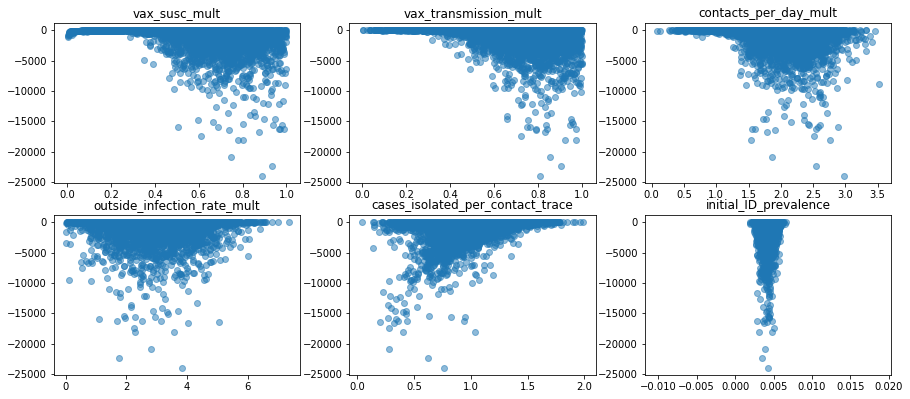

In [216]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))

for idx, param in enumerate(UNCERTAINTY_PARAMS):
    min_val = min([x for x in param_logliks[param] if x != float('-inf')])

    plt.subplot(3,3,idx+1)
    plt.scatter(param_vals[param], 
                [x if x != float('-inf') else min_val for x in param_logliks[param]],
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

In [217]:
import pandas as pd
df = pd.DataFrame(param_vals)
df['log_likelihood'] = param_logliks[UNCERTAINTY_PARAMS[0]]
df['combined_spread_mult'] = df['vax_transmission_mult'] * df['vax_susc_mult'] * \
                                      df['contacts_per_day_mult']
min_loglik = min(df[df['log_likelihood'] > -np.inf]['log_likelihood'])
df.replace(-np.inf, min_loglik, inplace=True)
df.shape

(11301, 8)

In [218]:
df.shape

(11301, 8)

In [219]:
likelihoods = [np.exp(loglik) for loglik in param_logliks[UNCERTAINTY_PARAMS[0]]]
df['likelihood'] = likelihoods

In [220]:
normalizer = df['likelihood'].sum()
df['posterior'] = df['likelihood'] / normalizer

In [221]:
import time
csv_name = time.strftime("posterior_csvs/%y_%m_%d_%H:%M_posteriors.csv", time.localtime())
df.to_csv(csv_name)

In [222]:
csv_name

'posterior_csvs/21_10_10_11:15_posteriors.csv'

In [243]:
df.columns

Index(['vax_susc_mult', 'vax_transmission_mult', 'contacts_per_day_mult',
       'outside_infection_rate_mult', 'cases_isolated_per_contact_trace',
       'initial_ID_prevalence', 'log_likelihood', 'combined_spread_mult',
       'likelihood', 'posterior'],
      dtype='object')

In [223]:
sorted_df = df.dropna().sort_values(by='posterior', ascending=False)

In [224]:
num_points = list(range(df.shape[0]))
posterior_mass = []

for n in num_points:
    subdf = sorted_df.head(n=n)
    posterior_mass.append(subdf['posterior'].sum())
    

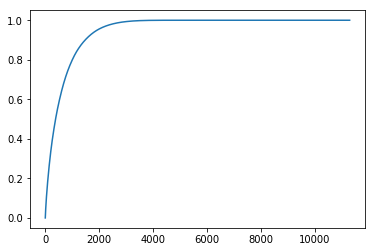

In [225]:
plt.plot(num_points, posterior_mass)

In [226]:
posterior_mass[428]

0.5341618385564295

Text(0.5,1,'number of points vs. posterior mass, using fixed likelihood values')

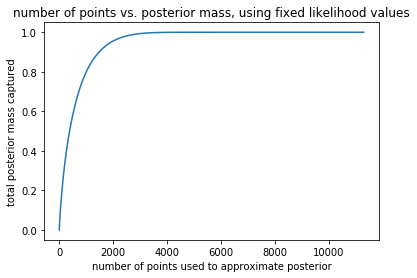

In [227]:
plt.plot(num_points, posterior_mass)
plt.xlabel("number of points used to approximate posterior")
plt.ylabel("total posterior mass captured")
plt.title("number of points vs. posterior mass, using fixed likelihood values")

Text(0.5,1,'distribution of log-normal log-likelihoods')

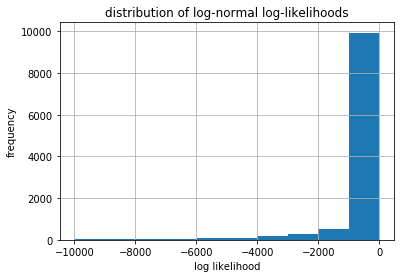

In [228]:
subdf = df[df['log_likelihood'] > -10000]
subdf['log_likelihood'].hist()
plt.xlabel('log likelihood')
plt.ylabel('frequency')
plt.title('distribution of log-normal log-likelihoods')

Text(0.5,1,'distribution of log-normal log-likelihoods')

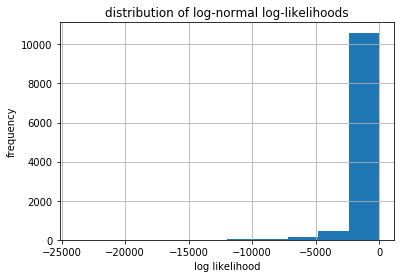

In [229]:
df['log_likelihood'].hist()
plt.xlabel('log likelihood')
plt.ylabel('frequency')
plt.title('distribution of log-normal log-likelihoods')

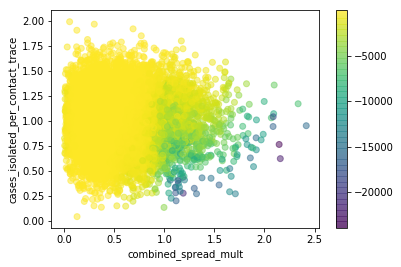

In [230]:
plt.scatter(df['combined_spread_mult'], df['cases_isolated_per_contact_trace'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

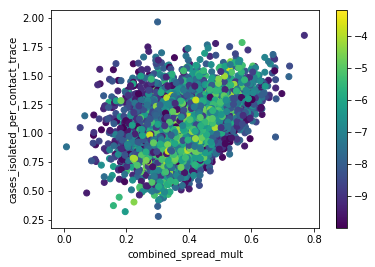

In [231]:
subdf = df[df['log_likelihood'] >= -10]
plt.scatter(subdf['combined_spread_mult'], subdf['cases_isolated_per_contact_trace'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

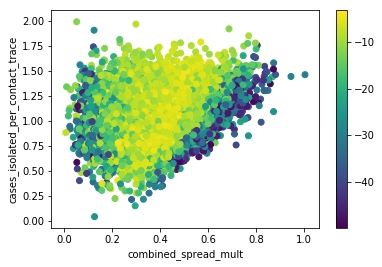

In [232]:
subdf = df[df['log_likelihood'] >= -50]
plt.scatter(subdf['combined_spread_mult'], subdf['cases_isolated_per_contact_trace'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('cases_isolated_per_contact_trace')
plt.colorbar()

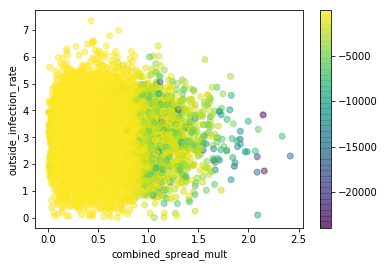

In [233]:
plt.scatter(df['combined_spread_mult'], df['outside_infection_rate_mult'],
           c=df['log_likelihood'], alpha=0.5)
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()
plt.show()



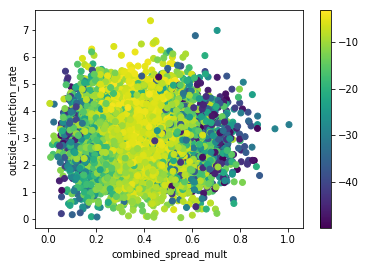

In [234]:
plt.scatter(subdf['combined_spread_mult'], subdf['outside_infection_rate_mult'],
           c=subdf['log_likelihood'])
plt.xlabel('combined_spread_mult')
plt.ylabel('outside_infection_rate')
plt.colorbar()

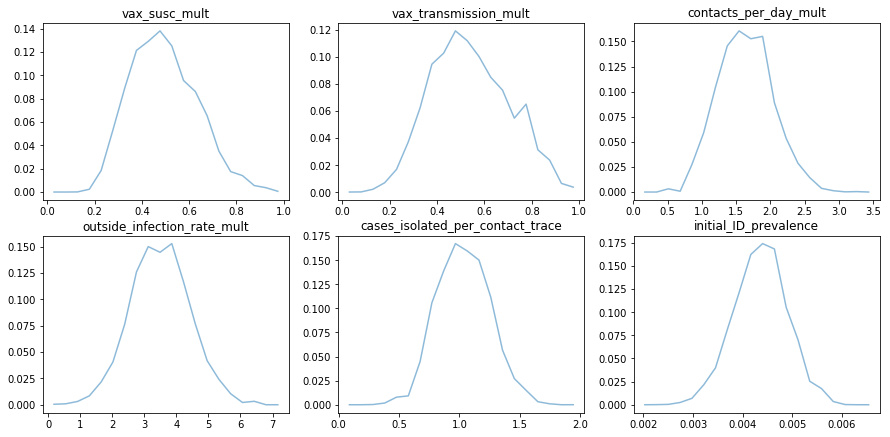

In [244]:
def estimate_marginal_dist(df, param, num_buckets=10):
    bin_boundaries = np.linspace(min(df[param]), max(df[param]), num=num_buckets+1)
    num_bins = len(bin_boundaries) - 1
    bin_centres = []
    bin_likelihoods = []
    for bin_start_idx in range((num_bins)):
        bin_start_val = bin_boundaries[bin_start_idx]
        bin_end_val = bin_boundaries[bin_start_idx + 1]
        bin_centres.append(0.5 * (bin_start_val + bin_end_val))
        
        subdf = df[(df[param] >= bin_start_val) & (df[param] < bin_end_val)]
        cum_posterior = 0
        for posterior in subdf['posterior']:

            cum_posterior += posterior
        
        
        bin_likelihoods.append(cum_posterior)
    return bin_centres, bin_likelihoods
        

plt.figure(figsize=(15,15))
num_buckets=20
for idx, param in enumerate(UNCERTAINTY_PARAMS):# + ['combined_spread_mult']):

    plt.subplot(4,3,idx+1)
    centres, likelihoods = estimate_marginal_dist(df, param, num_buckets=num_buckets)
    #print(param, likelihoods)
    plt.plot(centres, 
                likelihoods,
               alpha=0.5)
    #plt.xlabel("Parameter Value")
    #plt.ylabel("Estimated Log Likelihood")
    plt.title("{}".format(param))

# Code to compute symmetric 95% Credible Intervals

In [236]:
sorted_data = sorted(np.array(df[['vax_susc_mult', 'posterior']]), key=lambda x: x[0])

cum_posterior = 0
current_value = -1


In [237]:
def get_credible_interval(df, param, q=0.95):
    sorted_data = sorted(np.array(df[[param, 'posterior']]), key=lambda x: x[0])
    lower_q = (1 - q) / 2
    upper_q = q + lower_q
    cum_posterior = 0
    prev_cum_posterior = 0
    interval_lb = None
    interval_ub = None
    
    for param_val, posterior_mass in sorted_data:
        prev_cum_posterior = cum_posterior
        cum_posterior += posterior_mass
        
        if prev_cum_posterior < lower_q and cum_posterior >= lower_q:
            interval_lb = param_val
        
        if prev_cum_posterior < upper_q and cum_posterior >= upper_q:
            interval_ub = param_val
    
    return interval_lb, interval_ub

get_credible_interval(df, 'vax_transmission_mult', q=0.99)
        
    

(0.15889613730174718, 0.9399099187386123)

# code for pairwise marginal distribution

[0.21663052 0.35242972 0.48822892 0.62402812 0.75982731 0.89562651]
[0.15889614 0.31509889 0.47130165 0.62750441 0.78370716 0.93990992]


Text(0,0.5,'vax_transmission_mult')

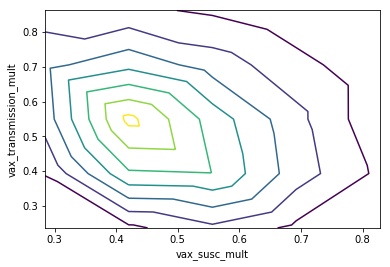

In [238]:
def estimate_pairwise_marginal_dist(df, param1, param2, num_bins=10):
    lb1, ub1 = get_credible_interval(df, param1, q=0.99)
    bin1_boundaries = np.linspace(lb1, ub1, num=num_bins+1)
    
    lb2, ub2 = get_credible_interval(df, param2, q=0.99)
    bin2_boundaries = np.linspace(lb2, ub2, num=num_bins+1)
    
    print(bin1_boundaries)
    print(bin2_boundaries)
    bin_xs = []
    bin_ys = []
    bin_likelihoods = []
    
    
    for bin1_start_idx in range((num_bins)):
        bin1_start_val = bin1_boundaries[bin1_start_idx]
        bin1_end_val = bin1_boundaries[bin1_start_idx + 1]
        bin1_centre = 0.5 * (bin1_start_val + bin1_end_val)
        
        for bin2_start_idx in range((num_bins)):
            bin2_start_val = bin2_boundaries[bin2_start_idx]
            bin2_end_val = bin2_boundaries[bin2_start_idx + 1]
            bin2_centre = 0.5 * (bin2_start_val + bin2_end_val)
        
            subdf = df[(df[param1] >= bin1_start_val) & (df[param1] < bin1_end_val) & \
                      (df[param2] >= bin2_start_val) & (df[param2] < bin2_end_val) ]
        
            cum_posterior = 0
            for posterior in subdf['posterior']:
                
                cum_posterior += posterior
        
            bin_likelihoods.append(cum_posterior)
            bin_xs.append(bin1_centre)
            bin_ys.append(bin2_centre)
    return bin_xs, bin_ys, bin_likelihoods
        

    
x, y, z = estimate_pairwise_marginal_dist(df, 'vax_susc_mult', 'vax_transmission_mult', num_bins=5)

plt.figure()
plt.tricontour(x,y,z)
plt.xlabel("vax_susc_mult")
plt.ylabel("vax_transmission_mult")

In [239]:
list(range(1,4))

[1, 2, 3]

In [240]:
pairs_of_params = []

for idx1 in range(len(UNCERTAINTY_PARAMS)):
    for idx2 in range(idx1 + 1, len(UNCERTAINTY_PARAMS)):
        pairs_of_params.append((UNCERTAINTY_PARAMS[idx1], UNCERTAINTY_PARAMS[idx2]))

In [241]:
len(pairs_of_params)

15

[0.21663052 0.35242972 0.48822892 0.62402812 0.75982731 0.89562651]
[0.15889614 0.31509889 0.47130165 0.62750441 0.78370716 0.93990992]
[0.21663052 0.35242972 0.48822892 0.62402812 0.75982731 0.89562651]
[0.80593151 1.17839148 1.55085145 1.92331143 2.2957714  2.66823137]
[0.21663052 0.35242972 0.48822892 0.62402812 0.75982731 0.89562651]
[1.1163004  2.10574289 3.09518538 4.08462786 5.07407035 6.06351284]
[0.21663052 0.35242972 0.48822892 0.62402812 0.75982731 0.89562651]
[0.48674866 0.70701076 0.92727287 1.14753497 1.36779708 1.58805918]
[0.21663052 0.35242972 0.48822892 0.62402812 0.75982731 0.89562651]
[0.00295887 0.00349461 0.00403034 0.00456608 0.00510182 0.00563755]
[0.15889614 0.31509889 0.47130165 0.62750441 0.78370716 0.93990992]
[0.80593151 1.17839148 1.55085145 1.92331143 2.2957714  2.66823137]
[0.15889614 0.31509889 0.47130165 0.62750441 0.78370716 0.93990992]
[1.1163004  2.10574289 3.09518538 4.08462786 5.07407035 6.06351284]
[0.15889614 0.31509889 0.47130165 0.62750441 0.7

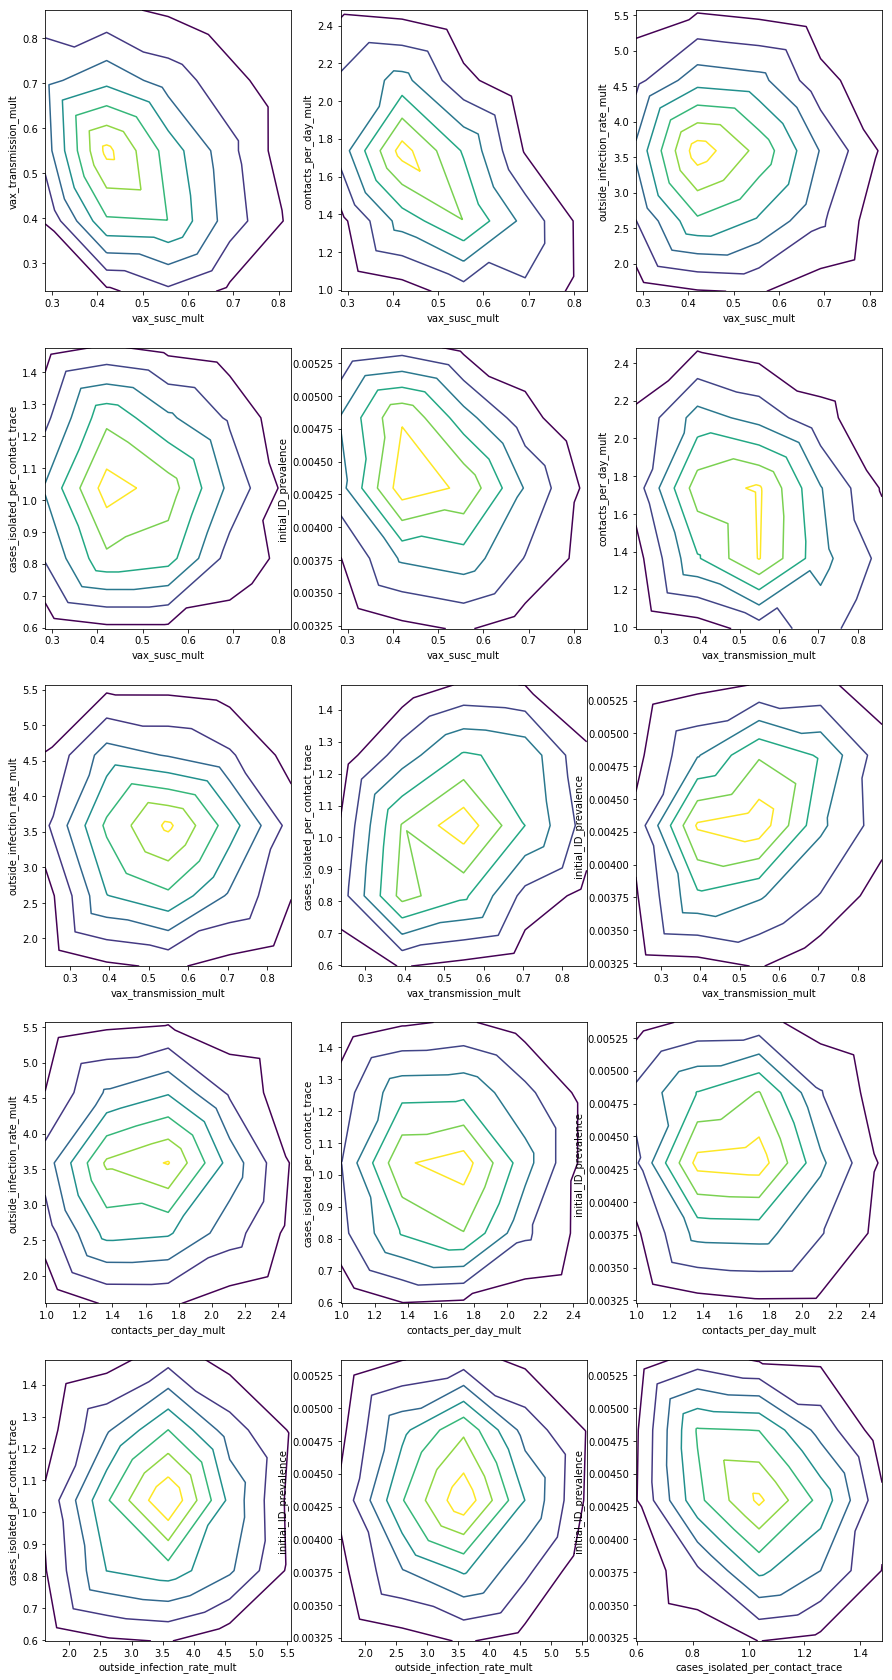

In [242]:
plt.figure(figsize=(15,30))

for idx, param_pair in enumerate(pairs_of_params):
    plt.subplot(5,3, idx+1)
    x, y, z = estimate_pairwise_marginal_dist(df, param_pair[0], param_pair[1], num_bins=5)

    plt.tricontour(x,y,z)
    plt.xlabel(param_pair[0])
    plt.ylabel(param_pair[1])

# code to recover filenames from point idxs, and plot trajectories from worst points

In [194]:
points_list = [[0.4081771157267468, 0.4808775989126969, 1.8551419314187731, 3.073294444516331, 0.7951453218063828, 0.0046323085300658115], [0.34208513930789164, 0.603490263778672, 2.259694669602522, 2.171331631352255, 0.9713262858023944, 0.004113969271582033], [0.7706463482673553, 0.2715791698837691, 1.9025831105347264, 4.876896538054254, 0.98966448566233, 0.0047008657628938725], [0.5866772199998616, 0.4872683016896559, 1.704958052515231, 3.8981073688722017, 1.131714594283583, 0.00328147331311157], [0.3750401453382676, 0.6373387270580978, 2.243788355598213, 1.5187645050545655, 1.1560631038315707, 0.003919732206092335], [0.32711079324674924, 0.7006094904203879, 1.888299459802121, 3.1714478356092988, 1.083007330990281, 0.004400483520551761], [0.40822197267715055, 0.6443668829572509, 1.9536651049929608, 3.3970433278835848, 1.0973958144435836, 0.004259772039109629]]


In [195]:
best_fs = []
best_f_errs = []

for point in points_list:
    best_f = None
    best_f_err = 1
    for f, point_f in sampled_points.items():
        err = np.linalg.norm(np.array(point_f) - np.array(point))
        if err < best_f_err:
            best_f_err = err
            best_f = f
    best_fs.append(best_f)
    best_f_errs.append(best_f_err)

In [196]:
best_fs

['fall_2021_prior_samples:1633813108/point_114_with_trajectories.dill',
 'fall_2021_prior_samples:1633813108/point_210_with_trajectories.dill',
 'fall_2021_prior_samples:1633813076/point_187_with_trajectories.dill',
 'fall_2021_prior_samples:1633813108/point_381_with_trajectories.dill',
 'fall_2021_prior_samples:1633812978/point_1107_with_trajectories.dill',
 'fall_2021_prior_samples:1633812978/point_1238_with_trajectories.dill',
 'fall_2021_prior_samples:1633812978/point_1343_with_trajectories.dill']

In [197]:
best_f_errs

[2.2887833992611187e-16,
 0.0,
 2.5438405243138006e-16,
 2.2204502844110104e-16,
 4.996011139989285e-16,
 0.0,
 4.440892098500626e-16]

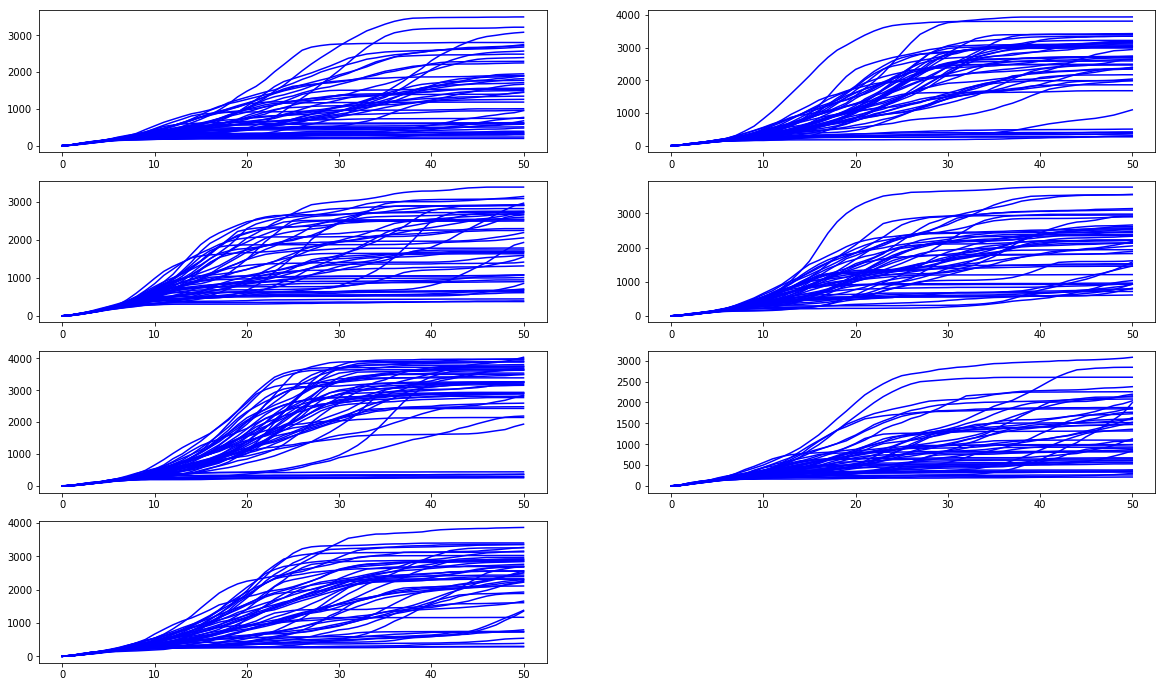

In [202]:
plt.figure(figsize=(20,12))
for idx, f in enumerate(best_fs):
    plt.subplot(4,2,idx+1)
    for traj_ in aggregated_trajs[f]:
        traj = np.array(traj_)
        plt.plot(list(range(len(traj))), traj, color='blue')

In [ ]:
plt.plot()

In [193]:
sampled_points[sampled_points_list[0]]

[0.8365611483629356,
 0.6930494125935556,
 1.5846099812816798,
 2.8975822266095594,
 1.1281729898771995,
 0.004592432943603183]

In [203]:
def compute_means_and_stddevs_by_week(cum_trajs):
    actual_weekly_traj = convert_daily_count_traj_to_weekly_count(ACTUAL_TRAJ)
    num_weeks = len(actual_weekly_traj)
    
    # estimate lognormal parameters
    log_counts_by_week = {week_idx:[] for week_idx in range(num_weeks)}
    for cum_traj in cum_trajs:
        weekly_counts = get_weekly_counts(cum_traj)
        for week_idx in range(num_weeks):
            log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx] + 1e-10))
            #log_counts_by_week[week_idx].append(np.log(weekly_counts[week_idx]))
    
    means_by_week = {week_idx: np.mean(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    stddevs_by_week = {week_idx: np.std(log_counts_by_week[week_idx]) for week_idx in range(num_weeks)}
    
    return means_by_week, stddevs_by_week

compute_means_and_stddevs_by_week(aggregated_trajs[best_fs[0]])

({0: 5.2119065420280535,
  1: 5.157704123762475,
  2: 4.846303882213196,
  3: 4.06794443339343,
  4: 4.082275522889614},
 {0: 0.09946781330206686,
  1: 0.7858334273944632,
  2: 1.282452736686347,
  3: 4.251582388358073,
  4: 2.0478813256304282})

# Do the same analysis with the best points

In [205]:
low_points_list = [[0.3665639640538837, 0.548670556548025, 1.9873057085800532, 3.4522871111748565, 0.9630337969452388, 0.004586124225796668], [0.23553019974106645, 0.6745276452996285, 1.5736014271527003, 3.1273863235748363, 0.6082308756853554, 0.005500147513038874], [0.4551611647731035, 0.3930383491539254, 1.4898289939381253, 4.294916130040846, 0.8373826778517874, 0.00501594231664779], [0.6247481813464292, 0.4687441274901236, 1.1777296789040506, 3.780669069696128, 1.1831599162868722, 0.004714261461631128], [0.3079937614410379, 0.5771159931032617, 2.511234387181125, 3.6132319236979185, 1.4221789742146491, 0.003956259846814769], [0.266951079383427, 0.6902995558127709, 1.9173258913098543, 3.0108934022009595, 1.076997053446863, 0.004679594649661242]]

In [206]:
best_fs = []
best_f_errs = []

for point in low_points_list:
    best_f = None
    best_f_err = 1
    for f, point_f in sampled_points.items():
        err = np.linalg.norm(np.array(point_f) - np.array(point))
        if err < best_f_err:
            best_f_err = err
            best_f = f
    best_fs.append(best_f)
    best_f_errs.append(best_f_err)

In [207]:
best_fs

['fall_2021_prior_samples:1633813017/point_169_with_trajectories.dill',
 'fall_2021_prior_samples:1633812978/point_488_with_trajectories.dill',
 'fall_2021_prior_samples:1633813076/point_307_with_trajectories.dill',
 'fall_2021_prior_samples:1633813108/point_330_with_trajectories.dill',
 'fall_2021_prior_samples:1633813076/point_473_with_trajectories.dill',
 'fall_2021_prior_samples:1633813017/point_450_with_trajectories.dill']

In [209]:
best_f_errs

[5.117875266520903e-16,
 4.449557262054371e-16,
 5.551792708129603e-17,
 4.47545209131181e-16,
 4.965068306494546e-16,
 2.220446049250313e-16]

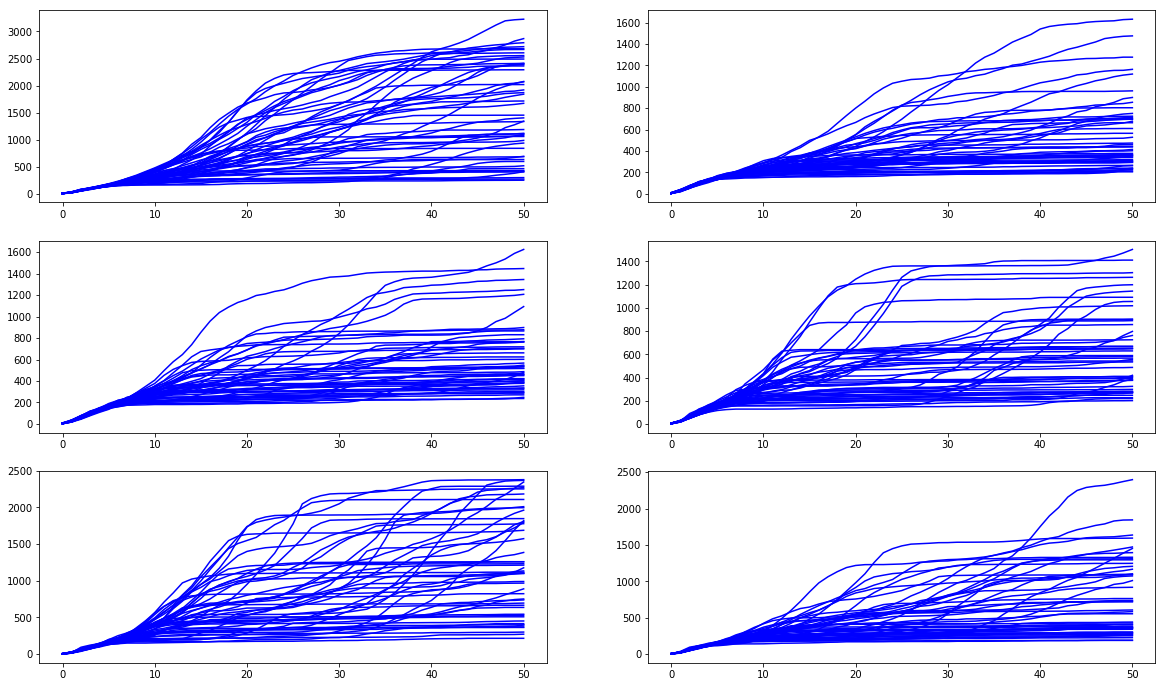

In [208]:
plt.figure(figsize=(20,12))
for idx, f in enumerate(best_fs):
    plt.subplot(3,2,idx+1)
    for traj_ in aggregated_trajs[f]:
        traj = np.array(traj_)
        plt.plot(list(range(len(traj))), traj, color='blue')